### Imports and Setup

In [12]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import mediapipe as mp
import cv2
from matplotlib import pyplot as plt
import json

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define gestures early
GESTURES = ["hello", "help", "good", "stop", "please"]

# Paths for Kaggle
VIDEO_PATH = "/kaggle/input/wlasl2000-resized/wlasl-complete/videos/"
LANDMARKS_PATH = "/kaggle/working/landmarks/"
MODEL_PATH = "/kaggle/working/models/"
os.makedirs(LANDMARKS_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

# Load WLASL JSON for labels (assuming it's in the dataset)
JSON_PATH = "/kaggle/input/wlasl2000-resized/wlasl-complete/WLASL_v0.3.json"
with open(JSON_PATH, 'r') as f:
    wlasl_metadata = json.load(f)

Using device: cuda


### Preprocess WLASL videos to landmarks

In [13]:
# Preprocess WLASL videos to landmarks
mp_hands = mp.solutions.hands.Hands(static_image_mode=False, max_num_hands=2)

# Build a mapping of video ID to gesture
video_to_gesture = {}
for entry in wlasl_metadata:
    gloss = entry['gloss'].lower()
    if gloss in GESTURES:
        for instance in entry['instances']:
            video_id = instance['video_id']
            video_to_gesture[video_id] = gloss

# Process videos
for video_file in os.listdir(VIDEO_PATH):
    if video_file.endswith('.mp4'):
        video_id = video_file.split('.')[0]  # e.g., "00001"
        if video_id in video_to_gesture:
            gesture = video_to_gesture[video_id]
            cap = cv2.VideoCapture(os.path.join(VIDEO_PATH, video_file))
            landmarks_list = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                results = mp_hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                if results.multi_hand_landmarks and len(results.multi_hand_landmarks) == 2:
                    landmarks = np.array([[lm.x, lm.y, lm.z] for hand in results.multi_hand_landmarks for lm in hand.landmark])
                    if landmarks.shape[0] == 42:  # 2 hands, 21 landmarks each
                        landmarks_list.append(landmarks)
            cap.release()
            if landmarks_list:
                avg_landmarks = np.mean(landmarks_list, axis=0)
                np.save(os.path.join(LANDMARKS_PATH, f"{gesture}_{video_id}.npy"), avg_landmarks)
                print(f"Saved landmarks for {gesture}_{video_id}")

# Check processed files
print(f"Processed files in {LANDMARKS_PATH}: {len(os.listdir(LANDMARKS_PATH))}")

Saved landmarks for hello_27181
Saved landmarks for stop_54926
Saved landmarks for help_27216
Saved landmarks for please_70220
Saved landmarks for please_43225
Saved landmarks for please_43218
Saved landmarks for help_27219
Saved landmarks for stop_54923
Saved landmarks for help_27211
Saved landmarks for hello_27183
Saved landmarks for help_65889
Saved landmarks for good_25067
Saved landmarks for help_65891
Saved landmarks for hello_27180
Saved landmarks for hello_68236
Saved landmarks for stop_54930
Saved landmarks for hello_27173
Saved landmarks for help_27218
Saved landmarks for help_27207
Saved landmarks for stop_54922
Saved landmarks for good_67723
Saved landmarks for help_27210
Saved landmarks for please_43224
Saved landmarks for good_25075
Saved landmarks for help_27194
Saved landmarks for good_69347
Saved landmarks for help_69364
Saved landmarks for hello_27175
Saved landmarks for stop_54915
Saved landmarks for hello_67755
Saved landmarks for good_25069
Saved landmarks for plea

### Data Loading and Dataset

In [20]:
# Custom Dataset class (unchanged)
class GestureDataset(Dataset):
    def __init__(self, data_dir, gesture_list):
        self.data_dir = data_dir
        self.gesture_list = gesture_list
        self.label_map = {gesture: idx for idx, gesture in enumerate(gesture_list)}
        self.data = []
        self.labels = []
        
        for gesture in gesture_list:
            for file in os.listdir(data_dir):
                if file.startswith(gesture) and file.endswith('.npy'):
                    landmarks = np.load(os.path.join(data_dir, file))
                    self.data.append(landmarks.flatten())
                    self.labels.append(self.label_map[gesture])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]

# Load dataset
dataset = GestureDataset(LANDMARKS_PATH, GESTURES)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)  # Add drop_last=True

# Check dataset size
print(f"Dataset size: {len(dataset)} samples")

Dataset size: 65 samples


### Model Definition

In [21]:
# Load pre-trained MobileNet and modify
model = models.mobilenet_v2(pretrained=True)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(GESTURES))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

Epoch [1/10], Loss: 0.3526
Epoch [2/10], Loss: 0.2122
Epoch [3/10], Loss: 0.0559
Epoch [4/10], Loss: 0.1616
Epoch [5/10], Loss: 0.0563
Epoch [6/10], Loss: 0.0508
Epoch [7/10], Loss: 0.0624
Epoch [8/10], Loss: 0.0281
Epoch [9/10], Loss: 0.0935
Epoch [10/10], Loss: 0.0386


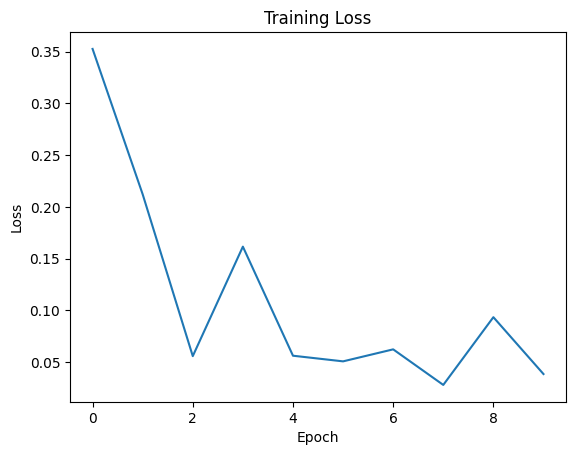

In [32]:
# Training function
def train_model(model, dataloader, num_epochs=10):
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(-1, 1, 14, 9)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    return losses

# Train the model
losses = train_model(model, dataloader)

# Plot loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

### Evaluation

In [33]:
# Quick evaluation
model.eval()
with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device).view(-1, 1, 14, 9)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        print(f"Predicted: {preds[:5]}, Actual: {labels[:5]}")
        break

Predicted: tensor([4, 1, 1, 4, 1], device='cuda:0'), Actual: tensor([4, 1, 1, 4, 1])


In [34]:
# Save the trained model
torch.save(model.state_dict(), os.path.join(MODEL_PATH, "mobilenet_gestures.pth"))
print("Model saved!")

Model saved!
